In [1]:
import pathlib, shutil, os, cv2
import numpy as np

def extract_image(source, destination, cascadeClassifier, cropped=True):
    """
    Extract image from a given video.

    Parameters
    ----------
    source : str
        The path of the source video.
    destination : str
        Directories where to save all of the extracted images.
    cascadeClassifier: str
        Cascade Classifier configuration xml file, which used to detect faces.
        Official link: https://github.com/opencv/opencv/blob/master/data/haarcascades/haarcascade_frontalface_default.xml
    cropped : boolean
        Boolean switch to control whether or not to crop the face in the image.

    Returns
    -------
    total_count: int
        Total generated images number.
    failed_count: int
        Failed generated images number.

    """
    vidcap = cv2.VideoCapture(source)

    success, image = vidcap.read()
    total_count, failed_count = 0, 0
    success = True
    while success:
        file_name = "frame%d.jpg" % total_count
        file = os.path.join(destination, file_name)
        
        # whether face detection needed or not
        if cropped == True:
            portrait_image = detect_crop_face(image, cascadeClassifier)
            if portrait_image is None:
                failed_count += 1
            else:
                cv2.imwrite(file, portrait_image)     # save frame as JPEG file
        else:
            cv2.imwrite(file, raw_portrait_image)
        
        success, image = vidcap.read() 
        if total_count % 100 == 0 and total_count > 0:
            print("Generated: {} photos in {}".format(total_count, destination))
        total_count += 1
    return total_count, failed_count


def detect_crop_face(image, faceCascade):
    """
    Detect face in image, extract and return the face image.
    
    Parameters
    ----------
    image: cv2.imread()
        the raw photo which contains the face, read by cv2.imread() funciton
    faceCascade: str
        Cascade Classifier configuration xml file, which used to detect faces.
        Official link: https://github.com/opencv/opencv/blob/master/data/haarcascades/haarcascade_frontalface_default.xml

    Returns
    -------
    : None
        No face detected.
    image : cv2.imread()
        detected face.

    """
    face_cascade = cv2.CascadeClassifier(faceCascade)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    if faces == ():
        return None
    else:
        for (x,y,w,h) in faces:
            return image[y:y+h, x:x+w]

In [2]:
def create_file_folders(base_dir=None):
    """
        Create base image directory for training datasets.

        Parameters
        ----------
        base_dir: str
            base images directory path.
            
        Returns
        train_dir : str
            Train directory path.
        validation_dir : str
            Validation directory path.
        test_dir : str
            Test directory path.
    """
    # Create root folder
    pathlib.Path(base_dir).mkdir(parents=True, exist_ok=True)

    # Create train, validation and test directory
    train_dir = os.path.join(base_dir, 'train')
    pathlib.Path(train_dir).mkdir(parents=True, exist_ok=True)

    validation_dir = os.path.join(base_dir, 'validation')
    pathlib.Path(validation_dir).mkdir(parents=True, exist_ok=True)

    test_dir = os.path.join(base_dir, 'test')
    pathlib.Path(test_dir).mkdir(parents=True, exist_ok=True)
    print('Root folder has created with subfolders train, test and validation')
    return train_dir, validation_dir, test_dir

"""
    target_list: people list
    target_folers: default to ['train', 'validation', 'test']
    base_dir: base directory
"""
def create_target_categories(target_list=None, target_folders=['train', 'validation', 'test'], base_dir=None):
    
    """
        Create each category folder under the train, validation and test folder.
        
        Parameters
        ----------
        target_list : list
            Target person list.
        target_folers : list
            Funciton folders, default to ['train', 'validation', 'test']
        base_dir: str
            base images directory path.
    """
    for directory in target_folders:
        function_dir = os.path.join(base_dir, directory)
        for person in target_list:
            person = os.path.join(function_dir, person)
            pathlib.Path(person).mkdir(parents=True, exist_ok=True)
            print("Folder", person, "has ready created")

In [3]:
def copy_images(target=None, proportion=None, base_dir=None, source_target_dir=None):
    """
    Copy target images and setup training structure.

    Parameters
    ----------
    target : list
        The person list whose photos need to be copied.
    proportion : list
        Train, validation, test photos number.
    base_dir: str
        Base directory path.
    source_target_dir : str
        The target person photos directory, this list should be the same order as target.

    """
    train_number, validation_number, test_number = proportion
    for person in target:
        photo_number = 0
        source_target = source_target_dir[target.index(person)]
        for file_name in os.listdir(source_target):
            if photo_number < train_number:
                _copy_image_process(person, base_dir, 'train', source_target, file_name)
            elif photo_number < train_number + validation_number:
                _copy_image_process(person, base_dir, 'validation', source_target, file_name)
            elif photo_number < train_number + validation_number + test_number:
                _copy_image_process(person, base_dir, 'test', source_target, file_name)
            photo_number += 1

def _copy_image_process(person=None, base_dir=None, category_dir=None, source_target_dir=None, file_name=None):
    """
    Inner function to copy image based on the given proporgation.

    Parameters
    ----------
    person : list
        The person list whose photos need to be copied.
    base_dir: str
        Base directory path.
    category_dir : list
        Train, validation, test should be provided.
    source_target_dir : str
        The target person photos directory, this list should be the same order as target.
    file_name : str
        The file_name which is saved.

    """
    
    # target file
    destination_function_dir = os.path.join(base_dir, category_dir)
    destination_target_dir = os.path.join(destination_function_dir, person)
    destination_target_name = os.path.join(destination_target_dir, file_name)
    # source file
    source_target_name = os.path.join(source_target_dir, file_name)
    shutil.copyfile(source_target_name, destination_target_name)

In [4]:
cascadeClassifier = 'haarcascade_frontalface_default.xml'

name_list = ['julie', 'melanie', 'xingda']
video_extension_name = ".mov"

# extract photos from videos
for person in name_list:
    source_name = person + video_extension_name
    destination_name = person
    pathlib.Path(destination_name).mkdir(parents=True, exist_ok=True)
    print("Start to generate image for {}". format(person))
    total_count, failed_count = extract_image(
        source=source_name,
        destination=destination_name,
        cascadeClassifier=cascadeClassifier)
    print("Image genration failure number: ", failed_count)
    print("Total generated image number:", total_count - failed_count)

Start to generate image for julie


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:77: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


Generated: 100 photos in julie
Generated: 200 photos in julie
Generated: 300 photos in julie
Generated: 400 photos in julie
Generated: 500 photos in julie
Image genration failure number:  42
Total generated image number: 464
Start to generate image for melanie
Generated: 100 photos in melanie
Generated: 200 photos in melanie
Generated: 300 photos in melanie
Image genration failure number:  0
Total generated image number: 388
Start to generate image for xingda
Generated: 100 photos in xingda
Generated: 200 photos in xingda
Generated: 300 photos in xingda
Generated: 400 photos in xingda
Image genration failure number:  10
Total generated image number: 471


In [5]:
# setup training structure

base_dir="faces"
proportion = [200, 100, 100]

train_dir, validation_dir, test_dir = create_file_folders(base_dir)
create_target_categories(name_list, base_dir=base_dir)
copy_images(name_list, proportion, base_dir, name_list)

Root folder has created with subfolders train, test and validation
Folder faces/train/julie has ready created
Folder faces/train/melanie has ready created
Folder faces/train/xingda has ready created
Folder faces/validation/julie has ready created
Folder faces/validation/melanie has ready created
Folder faces/validation/xingda has ready created
Folder faces/test/julie has ready created
Folder faces/test/melanie has ready created
Folder faces/test/xingda has ready created


In [12]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.applications.xception import Xception

num_classes = 3
channels = 3
height = 150
width = 150
batch_size = 16

conv_base = Xception(
    weights='imagenet',
    include_top=False,
    input_shape=(width, height, channels)
)

model = Sequential()
model.add(conv_base)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(num_classes, activation='sigmoid'))

# conv_base.summary()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 5, 5, 2048)        20861480  
_________________________________________________________________
flatten_3 (Flatten)          (None, 51200)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               13107456  
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 771       
Total params: 33,969,707
Trainable params: 33,915,179
Non-trainable params: 54,528
_________________________________________________________________


In [22]:
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
import keras

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=(0.5, 2.0),
#     zca_whitening=True,  # apply ZCA whitening
#     zca_epsilon=1e-06,  # epsilon for ZCA whitening, default is 1e-6
    shear_range=0.4,
    zoom_range=0.6,
    horizontal_flip=True,
    fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(width, height),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(width, height),
    batch_size=batch_size,
    class_mode='categorical')

callback_list = [
    # interrupts training when improving stops
    keras.callbacks.EarlyStopping(
        # monitor the model's validation accuracy
        monitor='acc',
        # patience=1 => interrupt training when accuracy has stoped improving for more than 1 epoch (that is 2 epoch)
        patience=3),
    
    # save the current weights after every epoch
    keras.callbacks.ModelCheckpoint(
        # path to the destination model file
        filepath='face_recognition.h5',
        # won't overwrite the model unless val_loss has improved.
        monitor='val_loss',
        save_best_only=True),
    
    # Use tensorboard to analysis result
    keras.callbacks.TensorBoard(
        log_dir='graph/train',
        histogram_freq=0,
        write_graph=True)
]

model.compile(
    loss='binary_crossentropy',
#     optimizer=optimizers.RMSprop(lr=1e-4),
#     optimizer=optimizers.Adam(amsgrad=True),
#     optimizer=optimizers.Adagrad(),
    optimizer=optimizers.Adadelta(),
    metrics=['acc'])

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=50,
    validation_data=validation_generator,
    validation_steps=50,
    callbacks=callback_list,
    workers=-1
)

# save model
model_json_file = model.to_json()
with open("face_recognition_model.json", "w") as json_file:
    json_file.write(model_json_file)

Found 600 images belonging to 3 classes.
Found 300 images belonging to 3 classes.
Epoch 1/50
100/100 [==============================] - 584s 6s/step - loss: 0.0062 - acc: 0.9979 - val_loss: 0.0016 - val_acc: 0.9992
Epoch 2/50
100/100 [==============================] - 573s 6s/step - loss: 0.0019 - acc: 0.9996 - val_loss: 0.0024 - val_acc: 0.9983
Epoch 3/50
100/100 [==============================] - 545s 5s/step - loss: 0.0011 - acc: 0.9994 - val_loss: 8.6032e-04 - val_acc: 1.0000
Epoch 4/50
100/100 [==============================] - 551s 6s/step - loss: 2.2674e-04 - acc: 1.0000 - val_loss: 8.9771e-04 - val_acc: 1.0000
Epoch 5/50
100/100 [==============================] - 556s 6s/step - loss: 0.0022 - acc: 0.9996 - val_loss: 8.2108e-04 - val_acc: 1.0000
Epoch 6/50
100/100 [==============================] - 534s 5s/step - loss: 0.0028 - acc: 0.9996 - val_loss: 0.0033 - val_acc: 0.9983
Epoch 7/50
100/100 [==============================] - 562s 6s/step - loss: 9.8572e-04 - acc: 0.9996 - va

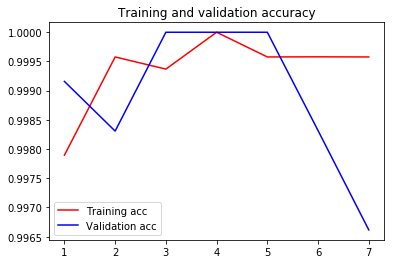

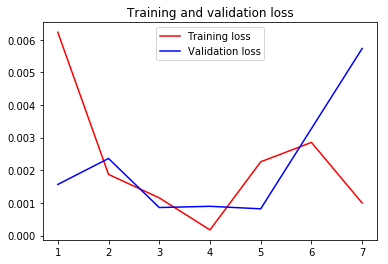

In [30]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
# plt.ylim(0.95, 1)
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [17]:
train_generator.class_indices

{'julie': 0, 'melanie': 1, 'xingda': 2}